github link: https://github.com/NicholasFelcher/CISB62_FINAL

#dataset https://magenta.tensorflow.org/datasets/maestro#download



# Music Generation LSTM neural network using the music21 library and maestro dataset

I created a LSTM neural network to generate song segments from classical piano pieces. To process the songs, I downloaded the Maestro dataset (midi only) to extract the midi files into a dataframe. Midi files contain the information for properties of each note, such as pitch, duration, and volume. To process the midi information, I used the music21 library, which let me turn notes and chords into objects. This made processing midi files manageable, and made this project possible. After processing all the data, I used train_test_split to separate test and validation sets. I trained my RNN from this data, and from its output, I was able to extract the note information and generate a song. I started off with a small amount of data in order to make sure everything worked, then I scaled everything up accordingly.

In [1]:
#!pip install music21

In [28]:
#import libraries
import pandas as pd
import numpy as np
import os
from statistics import mode

#data visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#warnings
import warnings
warnings.filterwarnings("ignore")

#audio display
import IPython
from IPython.display import Image, Audio

#http://web.mit.edu/music21/doc/index.html
#midi management library
import music21
from music21 import *

#tensorflow/keras
import tensorflow as tf
keras = tf.keras 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [3]:
#constants
NUMBER_OF_SONGS = 150
WANTED_INSTRUMENT = 'Piano'
NUMBER_OF_ELEMENTS_PER_SONG = 300

# EDA

Loading dataframe, checking data, cleaning data

In [4]:
#connect to the dataset
maestro_df = pd.read_csv('maestro-v3.0.0/maestro-v3.0.0.csv')

In [5]:
maestro_df.head()

,canonical_composer,canonical_title,split,year,midi_filename,audio_filename,duration
0,Alban Berg,Sonata Op. 1,train,2018,2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...,2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...,698.661160
1,Alban Berg,Sonata Op. 1,train,2008,2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MI...,2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MI...,759.518471
2,Alban Berg,Sonata Op. 1,train,2017,2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...,2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...,464.649433
3,Alexander Scriabin,"24 Preludes Op. 11, No. 13-24",train,2004,2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MI...,2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MI...,872.640588
4,Alexander Scriabin,"3 Etudes, Op. 65",validation,2006,2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MI...,2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MI...,397.857508


Remove unnecessary columns

In [6]:
#drop 'audio_filename', as i'm not using audio
maestro_df = maestro_df.drop(columns = ['audio_filename','split'], axis=1)
maestro_df.head(3)

,canonical_composer,canonical_title,year,midi_filename,duration
0,Alban Berg,Sonata Op. 1,2018,2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...,698.661160
1,Alban Berg,Sonata Op. 1,2008,2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MI...,759.518471
2,Alban Berg,Sonata Op. 1,2017,2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...,464.649433


In [7]:
#drop duplicate songs
maestro_df = maestro_df.drop_duplicates(subset=['canonical_composer', 'canonical_title'], keep='last')

In [8]:
#reset the index
maestro_df = maestro_df.reset_index(drop=True)
maestro_df.head()

,canonical_composer,canonical_title,year,midi_filename,duration
0,Alban Berg,Sonata Op. 1,2017,2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...,464.649433
1,Alexander Scriabin,"24 Preludes Op. 11, No. 13-24",2004,2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MI...,872.640588
2,Alexander Scriabin,"3 Etudes, Op. 65",2006,2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MI...,397.857508
3,Alexander Scriabin,"5 Preludes, Op.15",2009,2009/MIDI-Unprocessed_07_R1_2009_04-05_ORIG_MI...,400.557826
4,Alexander Scriabin,"Entragete, Op.63",2009,2009/MIDI-Unprocessed_11_R1_2009_06-09_ORIG_MI...,163.745830


In [9]:
maestro_df.info()
#no null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 856 entries, 0 to 855
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   canonical_composer  856 non-null    object 
 1   canonical_title     856 non-null    object 
 2   year                856 non-null    int64  
 3   midi_filename       856 non-null    object 
 4   duration            856 non-null    float64
dtypes: float64(1), int64(1), object(3)
memory usage: 33.6+ KB


In [10]:
maestro_df.describe()

,year,duration
count,856.000000,856.000000
mean,2011.411215,555.441272
std,4.239228,455.692141
min,2004.000000,45.155208
25%,2008.000000,252.855650
50%,2011.000000,397.454197
75%,2015.000000,687.451215
max,2018.000000,2624.663508


**Convert midi files to music21 objects**

In [11]:
#get the midi file and convert it to the 'song' object from music21
def get_midi_file(path):
    path = 'maestro-v3.0.0/' + path
    song = converter.parse(path)
    return song

**Restrict database to number of songs**

In [12]:
maestro_df = maestro_df.iloc[:NUMBER_OF_SONGS:2]

Create a list of song objects from midi files (takes awhile)

In [13]:
#create list of songs
song_list = []
maestro_df['midi_filename'].apply(lambda x: song_list.append(get_midi_file(x)))
print(song_list[0:10])

[<music21.stream.Score 0x2d2dc0797d0>, <music21.stream.Score 0x2d2dc079790>, <music21.stream.Score 0x2d2dc16e790>, <music21.stream.Score 0x2d2dc2ea850>, <music21.stream.Score 0x2d2dc593f50>, <music21.stream.Score 0x2d2dd590cd0>, <music21.stream.Score 0x2d2dc2cfed0>, <music21.stream.Score 0x2d2dfa7a150>, <music21.stream.Score 0x2d2de089b10>, <music21.stream.Score 0x2d2e05645d0>]


In [14]:
#add new column to dataframe
maestro_df['songs'] = song_list

In [15]:
maestro_df['songs'][0]

<music21.stream.Score 0x2d2dc0797d0>

**Get the name of the instruments in each song**

We only want songs with piano, so this method gets the instruments of each song so we can add it to the database and remove records without piano

In [16]:
#get instruments from song to delete any without piano
def get_instrument_names(song):
    instrument_names = []
    instruments = instrument.partitionByInstrument(song)
    for i in instruments:
        instrument_names.append(i.partName)
    return instrument_names

In [17]:
maestro_df['instruments'] = maestro_df['songs'].apply(lambda x: get_instrument_names(x))

In [18]:
maestro_df.head()

,canonical_composer,canonical_title,year,midi_filename,duration,songs,instruments
0,Alban Berg,Sonata Op. 1,2017,2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...,464.649433,[<music21.metadata.Metadata object at 0x2d2dc0...,[Piano]
2,Alexander Scriabin,"3 Etudes, Op. 65",2006,2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MI...,397.857508,[<music21.metadata.Metadata object at 0x2d2dbf...,[Piano]
4,Alexander Scriabin,"Entragete, Op.63",2009,2009/MIDI-Unprocessed_11_R1_2009_06-09_ORIG_MI...,163.745830,[<music21.metadata.Metadata object at 0x2d2dc2...,[Piano]
6,Alexander Scriabin,"Etude Op. 42, Nos. 4 & 5",2009,2009/MIDI-Unprocessed_02_R1_2009_03-06_ORIG_MI...,136.315302,[<music21.metadata.Metadata object at 0x2d2dc5...,[Piano]
8,Alexander Scriabin,"Etude in D-flat Major, Op. 8 No. 10",2011,2011/MIDI-Unprocessed_15_R1_2011_MID--AUDIO_R1...,102.007110,[<music21.metadata.Metadata object at 0x2d2dc3...,[Piano]


**Removing any song without piano from database**

In [19]:
maestro_df = maestro_df.reset_index(drop=True)

In [20]:
for i, value in enumerate(maestro_df['instruments']):
    if 'Piano' not in value:
        maestro_df = maestro_df.drop(i,inplace = False)
        
maestro_df = maestro_df.reset_index(drop=True)

In [21]:
maestro_df.head(5)

,canonical_composer,canonical_title,year,midi_filename,duration,songs,instruments
0,Alban Berg,Sonata Op. 1,2017,2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...,464.649433,[<music21.metadata.Metadata object at 0x2d2dc0...,[Piano]
1,Alexander Scriabin,"3 Etudes, Op. 65",2006,2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MI...,397.857508,[<music21.metadata.Metadata object at 0x2d2dbf...,[Piano]
2,Alexander Scriabin,"Entragete, Op.63",2009,2009/MIDI-Unprocessed_11_R1_2009_06-09_ORIG_MI...,163.745830,[<music21.metadata.Metadata object at 0x2d2dc2...,[Piano]
3,Alexander Scriabin,"Etude Op. 42, Nos. 4 & 5",2009,2009/MIDI-Unprocessed_02_R1_2009_03-06_ORIG_MI...,136.315302,[<music21.metadata.Metadata object at 0x2d2dc5...,[Piano]
4,Alexander Scriabin,"Etude in D-flat Major, Op. 8 No. 10",2011,2011/MIDI-Unprocessed_15_R1_2011_MID--AUDIO_R1...,102.007110,[<music21.metadata.Metadata object at 0x2d2dc3...,[Piano]


In [22]:
#recreate song_list with new values (from dataframe)
song_list = []
maestro_df['midi_filename'].apply(lambda x: song_list.append(get_midi_file(x)))

0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
11    None
12    None
13    None
14    None
15    None
16    None
17    None
18    None
19    None
20    None
21    None
22    None
23    None
24    None
25    None
26    None
27    None
28    None
29    None
30    None
31    None
32    None
33    None
34    None
35    None
36    None
37    None
38    None
39    None
40    None
Name: midi_filename, dtype: object

**Create a list of notes for each song**

In [29]:
def create_note_column(song_list, wanted_instrument):
    songs = []
    pick = ''
    for song in song_list:
        #notes is a list full of dictionaries
        #each note has many elements, including pitch, and duration (in quarter note length)
        #i'll be storing that information in the dictionary called 'attributes'
        #notes that are played at the same time are called "chords"
        #these notes will be listed in the same index
        notes = []
        count = 0
        
        #get list of instruments in the song
        instruments = instrument.partitionByInstrument(song)
        #placeholder
        relevant_instrument_obj = ''
        #checks for wanted instrument
        for i in instruments:
            if i.partName == wanted_instrument:
                relevant_instrument_obj = i
        #attributes dictionary contains all note information
        pick = relevant_instrument_obj.recurse()
        for element in pick:
            attributes = {}
            if count > NUMBER_OF_ELEMENTS_PER_SONG:
                break
            ##FOR NOTES
            if isinstance(element, note.Note):
                attributes['pitch'] = str(element.pitch)
                attributes['duration'] = str(element.duration.quarterLength)
                notes.append(attributes)
            
            ##FOR CHORDS
            elif isinstance(element, chord.Chord):
                attributes['pitch'] = ''
                attributes['duration'] = ''
                #iterate through each note in the chord
                for i in range(len(element.notes)):
                    attributes['pitch'] += str(element[i].pitch) + ' '
                    attributes['duration'] += str(element[i].duration.quarterLength) + ' '
                attributes['pitch'], attributes['duration'] = attributes['pitch'][0:-1], attributes['duration'][0:-1]
                notes.append(attributes)
            count += 1
        #if none
        if not notes:
            songs.append(None)
        else: 
            songs.append(notes)
    return songs

In [30]:
maestro_df['notes'] = create_note_column(song_list, WANTED_INSTRUMENT)

In [31]:
maestro_df.head()

,canonical_composer,canonical_title,year,midi_filename,duration,songs,instruments,notes
0,Alban Berg,Sonata Op. 1,2017,2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...,464.649433,[<music21.metadata.Metadata object at 0x2d2dc0...,[Piano],"[{'pitch': 'G4', 'duration': '5/3'}, {'pitch':..."
1,Alexander Scriabin,"3 Etudes, Op. 65",2006,2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MI...,397.857508,[<music21.metadata.Metadata object at 0x2d2dbf...,[Piano],"[{'pitch': 'E3 D4 B-3 G#5', 'duration': '1.0 1..."
2,Alexander Scriabin,"Entragete, Op.63",2009,2009/MIDI-Unprocessed_11_R1_2009_06-09_ORIG_MI...,163.745830,[<music21.metadata.Metadata object at 0x2d2dc2...,[Piano],"[{'pitch': 'A4', 'duration': '2.0'}, {'pitch':..."
3,Alexander Scriabin,"Etude Op. 42, Nos. 4 & 5",2009,2009/MIDI-Unprocessed_02_R1_2009_03-06_ORIG_MI...,136.315302,[<music21.metadata.Metadata object at 0x2d2dc5...,[Piano],"[{'pitch': 'G#5', 'duration': '2.0'}, {'pitch'..."
4,Alexander Scriabin,"Etude in D-flat Major, Op. 8 No. 10",2011,2011/MIDI-Unprocessed_15_R1_2011_MID--AUDIO_R1...,102.007110,[<music21.metadata.Metadata object at 0x2d2dc3...,[Piano],"[{'pitch': 'G#3 E4 C4', 'duration': '1.0 1.0 1..."


### Now I have a dataframe where i have the notes paired with the song title, composer, instruments, and midi object.

# Preprocessing

**Create corpus of notes for our model**

I will be putting pitches first, then durations after. This works out pretty easily since to retrieve and separate them later, all I have to do is split the string elements in half and assign them to their appropriate locations.

In [32]:
Corpus = []
for i in maestro_df['notes']:
    for note in i:
        cor = ''
        cor += note['pitch'] + ' '
        cor += note['duration']
        Corpus.append(cor)

In [33]:
Corpus

['G4 5/3',
 'C5 0.75',
 'F#5 B4 1.0 1.0',
 'C#4 1.5',
 'G4 4/3',
 'F#5 B4 1.0 1.0',
 'C#4 2.75',
 'G4 13/6',
 'G5 1.0',
 'G5 G4 1.0 1.0',
 'C4 4/3',
 'B-4 G4 1.0 1.0',
 'E-5 0.5',
 'E-5 B3 A4 1.0 1.0 1.0',
 'C4 1/3',
 'G4 0.75',
 'B4 1/3',
 'D5 B-3 E4 1.0 1.0 1.0',
 'G#4 1.0',
 'G4 1/3',
 'G4 0.75',
 'C#5 0.25',
 'F#2 G4 1.0 1.0',
 'C#5 2.25',
 'B-3 1.0',
 'F#4 1/3',
 'B1 4/3',
 'F#4 1.25',
 'D4 1.25',
 'B1 1/3',
 'F#4 3.0',
 'D4 25/12',
 'F#2 0.5',
 'B2 1.0',
 'D5 1.0',
 'B-4 D4 1.0 1.0',
 'F#4 0.25',
 'C4 0.5',
 'F5 1.5',
 'A4 F4 1.0 1.0',
 'C#4 2.75',
 'E5 0.25',
 'E5 1.75',
 'B-4 1.0',
 'F#4 0.5',
 'D4 0.25',
 'B4 D4 1.0 1.0',
 'G4 0.25',
 'B4 D4 1.0 1.0',
 'G4 0.5',
 'F5 0.5',
 'E5 0.5',
 'E-5 F#4 1.0 1.0',
 'E-4 1.0',
 'B-4 1/3',
 'B-4 0.25',
 'B3 D5 1.0 1.0',
 'A5 E-5 1.0 1.0',
 'F#3 0.5',
 'C#5 0.25',
 'C#5 F4 1.0 1.0',
 'C#5 F4 1.0 1.0',
 'B-5 1.0',
 'F#4 B-4 F#5 1.0 1.0 1.0',
 'D5 1/3',
 'G4 B4 1.0 1.0',
 'C#6 D6 1.0 1.0',
 'B4 G4 1.0 1.0',
 'A5 0.5',
 'C5 G#4 1.0 1.0',
 'F5 

**Remove some of most common elements**

In [34]:
#removing some of the most % of the most common elements to increase diversity in the dataset
for i in range(len(Corpus)//8):
    element = mode(Corpus)
    Corpus.remove(element)

In [35]:
mode(Corpus)

'B3 0.25'

**MAPPING OUR CORPUS TO RETRIEVE NOTE DATA AFTER LSTM PROCESSES THE INFORMATION**

Since the output will be decimal between 0 and 1, we need a way to retrieve note information from our model. The model will work with the index of a chord or note, and that index will be translated later back to the note information. To retrieve it back, we simply get the appropriate index after the model is finished.

In [36]:
symb = (list(set(Corpus)))

L_corpus = len(Corpus) #length of corpus
L_symb = len(symb) #length of total unique characters

#Building dictionary to access the vocabulary from indices and vice versa
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)

Total number of characters: 6670
Number of unique characters: 3024


In [37]:
#number of notes per feature, taken from the whole corpus
#number of notes will be same as the number of elements in a song, so each feature is a song since
#every song has more than 50 elements
length = int(NUMBER_OF_ELEMENTS_PER_SONG // 3)
ftrs = []
targets = []
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    ftrs.append([mapping[j] for j in feature])
    targets.append(mapping[target])
    
    
L_datapoints = len(targets)

In [38]:
X = (np.reshape(ftrs, (L_datapoints, length, 1)))/ float(L_symb)
# one hot encode the output variable
y = tf.keras.utils.to_categorical(targets) 

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LSTM Deep learning model

My input layer is a LSTM layer.
I dropped out 20% to try and avoid overfitting.
This followed by another LSTM layer in my hidden layer.
I also have a dense layer with a leaky relu activation to try and avoid the dead neuron problem, as I was getting repetitive results. My output layer is a 1 dimensional softmax dense layer. (my y.shape[1] is 1)

In [40]:
model = Sequential()
model.add(LSTM(128, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
#Using leakyrelu to try and solve the 'dead neuron' problem
model.add(Dense(64, activation=keras.layers.LeakyReLU(alpha=0.03)))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))
#compiling the model  
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 128)          66560     
                                                                 
 dropout (Dropout)           (None, 100, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3024)              196560    
                                                                 
Total params: 316688 (1.21 MB)
Trainable params: 316688 

**Fit the model**

In [42]:
history = model.fit(X_train, y_train, batch_size=32, epochs=70)

Epoch 1/70
165/165 [==============================] - 11s 52ms/step - loss: 7.9832
Epoch 2/70
165/165 [==============================] - 9s 56ms/step - loss: 7.7082
Epoch 3/70
165/165 [==============================] - 9s 56ms/step - loss: 7.6474
Epoch 4/70
165/165 [==============================] - 9s 55ms/step - loss: 7.6309
Epoch 5/70
165/165 [==============================] - 9s 54ms/step - loss: 7.6189
Epoch 6/70
165/165 [==============================] - 9s 52ms/step - loss: 7.6108
Epoch 7/70
165/165 [==============================] - 9s 54ms/step - loss: 7.6095
Epoch 8/70
165/165 [==============================] - 8s 51ms/step - loss: 7.6041
Epoch 9/70
165/165 [==============================] - 9s 53ms/step - loss: 7.6424
Epoch 10/70
165/165 [==============================] - 9s 52ms/step - loss: 7.6020
Epoch 11/70
165/165 [==============================] - 9s 53ms/step - loss: 7.6062
Epoch 12/70
165/165 [==============================] - 9s 52ms/step - loss: 7.6022
Epoch 13/70


In [43]:
model.save('model8')

INFO:tensorflow:Assets written to: model8\assets


INFO:tensorflow:Assets written to: model8\assets


[Text(0.5, 0, 'Epochs')]

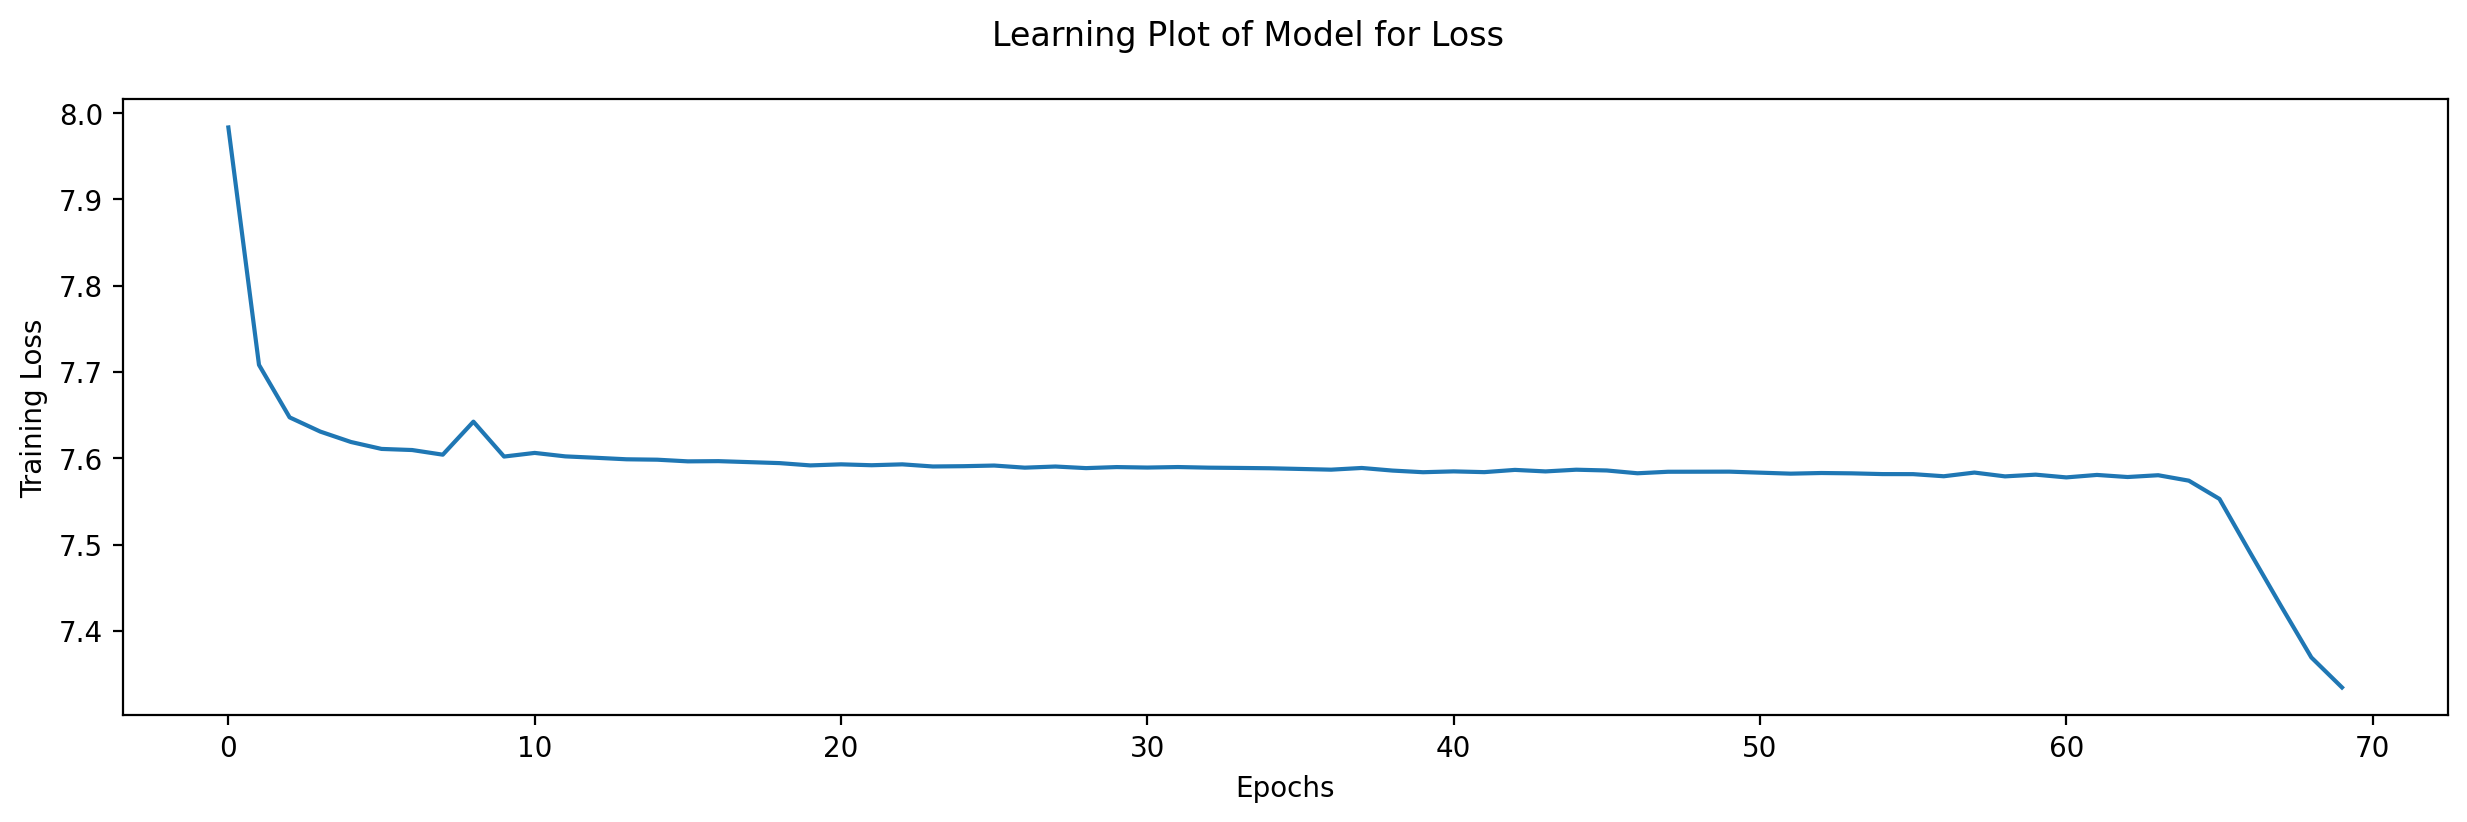

In [44]:
history_df = pd.DataFrame(history.history)
fig = plt.figure(figsize=(15,4))
fig.suptitle("Learning Plot of Model for Loss")
pl=sns.lineplot(data=history_df["loss"])
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")

In [45]:
predictions = model.predict(X_test)

42/42 [==============================] - 1s 18ms/step


In [46]:
max_val = max(list(reverse_mapping.keys()))
max_val

3023

In [47]:
def generate_song(Note_Count,seed):
    music = []
    Notes_Generated=[]
    prediction = predictions[seed]
    max_pred = max(prediction)
    for i in range(Note_Count):
        predicted_value = prediction[i]
        #converting small numbers into a range for our mapping index
        index = ((predicted_value / max_pred) * max_val)//1 #floor divisibility to get closest index
        index = int(index)
        music.append(index)          
    
    #convert index into values
    note_list = []
    for i in music:
        for key,value in reverse_mapping.items():
            if i == key:
                note_list.append(value)
    return note_list

In [48]:
music_notes = generate_song(40,2)

In [49]:
#check notes
music_notes[:50]

['D3 A4 1.0 1.0',
 'F#3 1/6',
 'C#4 2/3',
 'E5 G#5 G4 F#4 1.0 1.0 1.0 1.0',
 'G#2 F4 1.0 1.0',
 'D6 C5 E-6 C#5 1.0 1.0 1.0 1.0',
 'G#2 F4 1.0 1.0',
 'G4 C3 1.0 1.0',
 'D4 C#4 1.0 1.0',
 'G#4 C5 1.0 1.0',
 'A4 F#3 E5 1.0 1.0 1.0',
 'E-3 B5 B3 1.0 1.0 1.0',
 'B-6 B-5 1.0 1.0',
 'D4 F#5 E4 1.0 1.0 1.0',
 'E4 C4 1.0 1.0',
 'B2 E5 E3 A5 1.0 1.0 1.0 1.0',
 'E5 E6 E-6 E-5 1.0 1.0 1.0 1.0',
 'D5 D4 1.0 1.0',
 'G#2 F4 1.0 1.0',
 'A6 C#7 F#7 E-7 G#7 F7 E7 G7 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0',
 'B-3 0.5',
 'E-5 C#5 1.0 1.0',
 'G#2 F4 1.0 1.0',
 'B-4 G4 1.0 1.0',
 'E-6 1.75',
 'F#4 F#3 D4 1.0 1.0 1.0',
 'G#2 0.75',
 'E-6 C#5 E6 1.0 1.0 1.0',
 'G2 0.75',
 'B-3 F#4 B-5 E-5 1.0 1.0 1.0 1.0',
 'E4 B3 G3 1.0 1.0 1.0',
 'B-4 F#4 D4 B3 1.0 1.0 1.0 1.0',
 'F#5 23/12',
 'G4 C3 1.0 1.0',
 'E-4 C5 A3 1.0 1.0 1.0',
 'B2 0.5',
 'E-3 5/3',
 'F#5 G5 A5 1.0 1.0 1.0',
 'B-4 G4 E5 1.0 1.0 1.0',
 'G#4 F#5 1.0 1.0']

## Now I need to split the notes back into pitch/duration and convert it back to music21 format
To do this i will split each element into a list. It will sort the values into the pitch category until it reaches the halfway point, then it will sort them into the duration category. After they're separated, i'll connect them by index into a note object. After I have all the notes and chords, i'll convert that into a midi file, then wav file.

**SPLIT MUSIC_NOTES INTO A LIST OF PROPERTIES**

In [50]:
def split_music_properties(music):
    music_list = []
    for i in music:
        pitch = []
        duration = []
        items = i.split(' ')
        length = len(items)
        for index, value in enumerate(items):
            if index < length/2:
                pitch.append(value)
            else:
                duration.append(value)
        attributes = {'pitch':pitch, 'duration':duration}
        music_list.append(attributes)
        
    return(music_list)

In [51]:
generated_music = split_music_properties(music_notes)

In [52]:
#check values
generated_music[:10]

[{'pitch': ['D3', 'A4'], 'duration': ['1.0', '1.0']},
 {'pitch': ['F#3'], 'duration': ['1/6']},
 {'pitch': ['C#4'], 'duration': ['2/3']},
 {'pitch': ['E5', 'G#5', 'G4', 'F#4'],
  'duration': ['1.0', '1.0', '1.0', '1.0']},
 {'pitch': ['G#2', 'F4'], 'duration': ['1.0', '1.0']},
 {'pitch': ['D6', 'C5', 'E-6', 'C#5'],
  'duration': ['1.0', '1.0', '1.0', '1.0']},
 {'pitch': ['G#2', 'F4'], 'duration': ['1.0', '1.0']},
 {'pitch': ['G4', 'C3'], 'duration': ['1.0', '1.0']},
 {'pitch': ['D4', 'C#4'], 'duration': ['1.0', '1.0']},
 {'pitch': ['G#4', 'C5'], 'duration': ['1.0', '1.0']}]

**CONSTRUCTING NOTE OBJECTS**

In [53]:
note = music21.note
def create_note(pitch, duration):
    a = note.Note(pitch)
    a.quarterLength = float(duration)
    return a
    
def create_chord(pitches, durations):
    currentchord = chord.Chord(pitches)
    #match duration of note with same index of our durations list
    for index,a_note in enumerate(currentchord.notes):
        a_note.quarterLength = float(durations[index])
    return currentchord

def construct_notes(music):
    note_list = []
    for i in music:
        pitches = [item for item in i['pitch'] if not item.isdigit()]
        durations = i['duration']
        #remove fractional durations
        for index, value in enumerate(durations):
            if type(value) == str:
                if '/' in value:
                    durations[index] = '1.0'
            #remove any long duration
                elif float(value) > 20:
                    durations[index] = '1.0'
        # FOR SINGLE NOTES        
        if len(pitches) == 1:
            note_list.append(create_note(pitches[0], durations[0]))
        #FOR CHORDS
        elif len(pitches) >= 1: 
            note_list.append(create_chord(pitches,durations))
    
    return note_list
            

In [54]:
note_list = construct_notes(generated_music)

In [55]:
note_list[:5]

[<music21.chord.Chord D3 A4>,
 <music21.note.Note F#>,
 <music21.note.Note C#>,
 <music21.chord.Chord E5 G#5 G4 F#4>,
 <music21.chord.Chord G#2 F4>]

**CONVERT to MIDI**

In [56]:
song_stream = stream.Stream()
for i in note_list:
    song_stream.append(i)

In [57]:
song_stream.show('midi')

# Samples (Putting everything together)

In [58]:
def create_music(seed, number_of_notes):
    
    music = generate_song(number_of_notes,seed)
    music = split_music_properties(music)
    music = construct_notes(music)
    s = stream.Stream()
    for i in music:
        s.append(i)
    s.show('midi')
    return s

In [59]:
s = create_music(5,100)

In [60]:
s2 = create_music(0,100)

In [61]:
s3 = create_music(2,50)

In [62]:
s4 = create_music(13,100)

# Challenges
The main challenge with this project was properly extracting the notes and their information. All examples I was looking at seemed to do this step improperly, as they made the length of all notes the same. I wanted to incorporate more nuances in music in my project, but the limitations of music21 made me scale back my ideas. I was able to figure out how to incorporate duration information and extract it, but it took a lot of time to figure out how music21 works. Music21’s documentation isn’t the easiest to follow but after much trial and error I figured it out. Another big issue I had with this project was having enough memory on my machine to get the results I wanted. Since I had data for the pitch and length of each note, I had a fairly large dataset to process. Because of this, I had to scale down the amount of songs I used, and also the amount of notes in each song. I think this stunted the development of my model and which is why it could be improved. I also had an issue with overfitting, as after fitting my model, I would notice sometimes that a bunch of the same note or chord would be played in a row, or some songs would sound very similar. I tried to fix this by increasing the amount of dropout I used, scaling down the amount of nodes I had for some layers, and increasing the volume and variety of data.

# Conclusion
Overall, I had a lot of fun with this project. Music is a big passion of mine and creating a neural network capable of generating a simple piece was very satisfying. I learned a lot about midi, data preparation, overfitting, and scaling a project. I think this model can be greatly improved upon with a much larger dataset, and more care with dealing with the overfitting problem. I also in the future want to try and implement more musical nuance to the model, as I think that’s an area that is lacking in a lot of music generation models.